In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma_multistep import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'multi_step_1kpc'
seed = 0

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':[],
                'stationary_potential_kwargs_list':[],
                'dynamic_potential_list':['point_source','point_source'],
                'dynamic_potential_kwargs_list':[{'M':1e4}, {'M':1e4}, {'M':10}],
                'seed':seed,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params):
    env.reset()
    print(init_params)
    _, reward, _, _, info = env.step(init_params, single_step=True)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6], orbit.y[agent*6+1], orbit.y[agent*6+2], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6], orbit_delta.y[agent*6+1], orbit_delta.y[agent*6+2], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0], orbit.y[agent*6+1], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0], orbit_delta.y[agent*6+1], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    ax3 = fig.add_subplot(133)
    ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0.5, 1.0, 'Initial positions studied, projected on the XY plane')

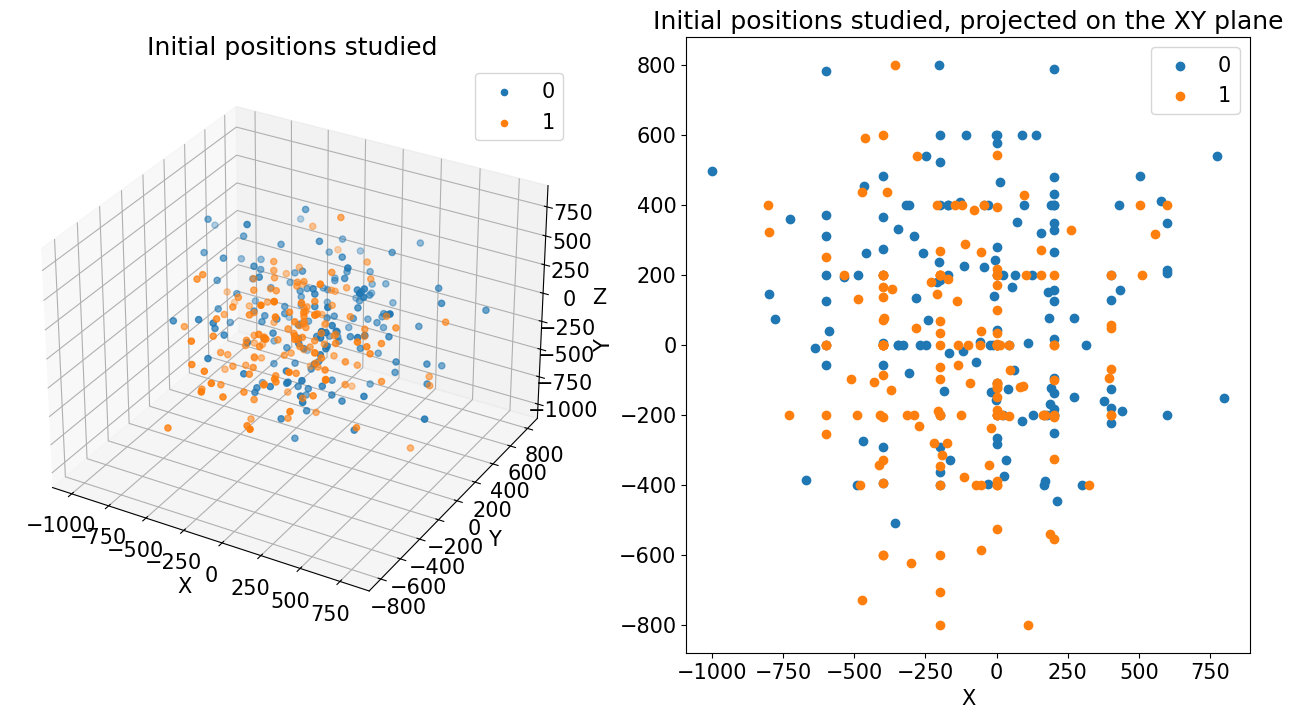

In [5]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('Initial positions studied')

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.set_title('Initial positions studied, projected on the XY plane')

In [6]:
def result_to_init(i):
    return {agent:(result_init_params[agent][:,i]) for agent in range(env.num_agents)}

{0: array([ 13.35366666, 465.92021734,   0.        ,  -0.63277036,
        -2.25430225,   0.53400211]), 1: array([400.        , 200.        ,  22.53249884,  -1.08266427,
        -2.        ,  -0.59247611])}
{0: np.float64(0.0004126697628450596), 1: np.float64(0.0004265132302492636)}


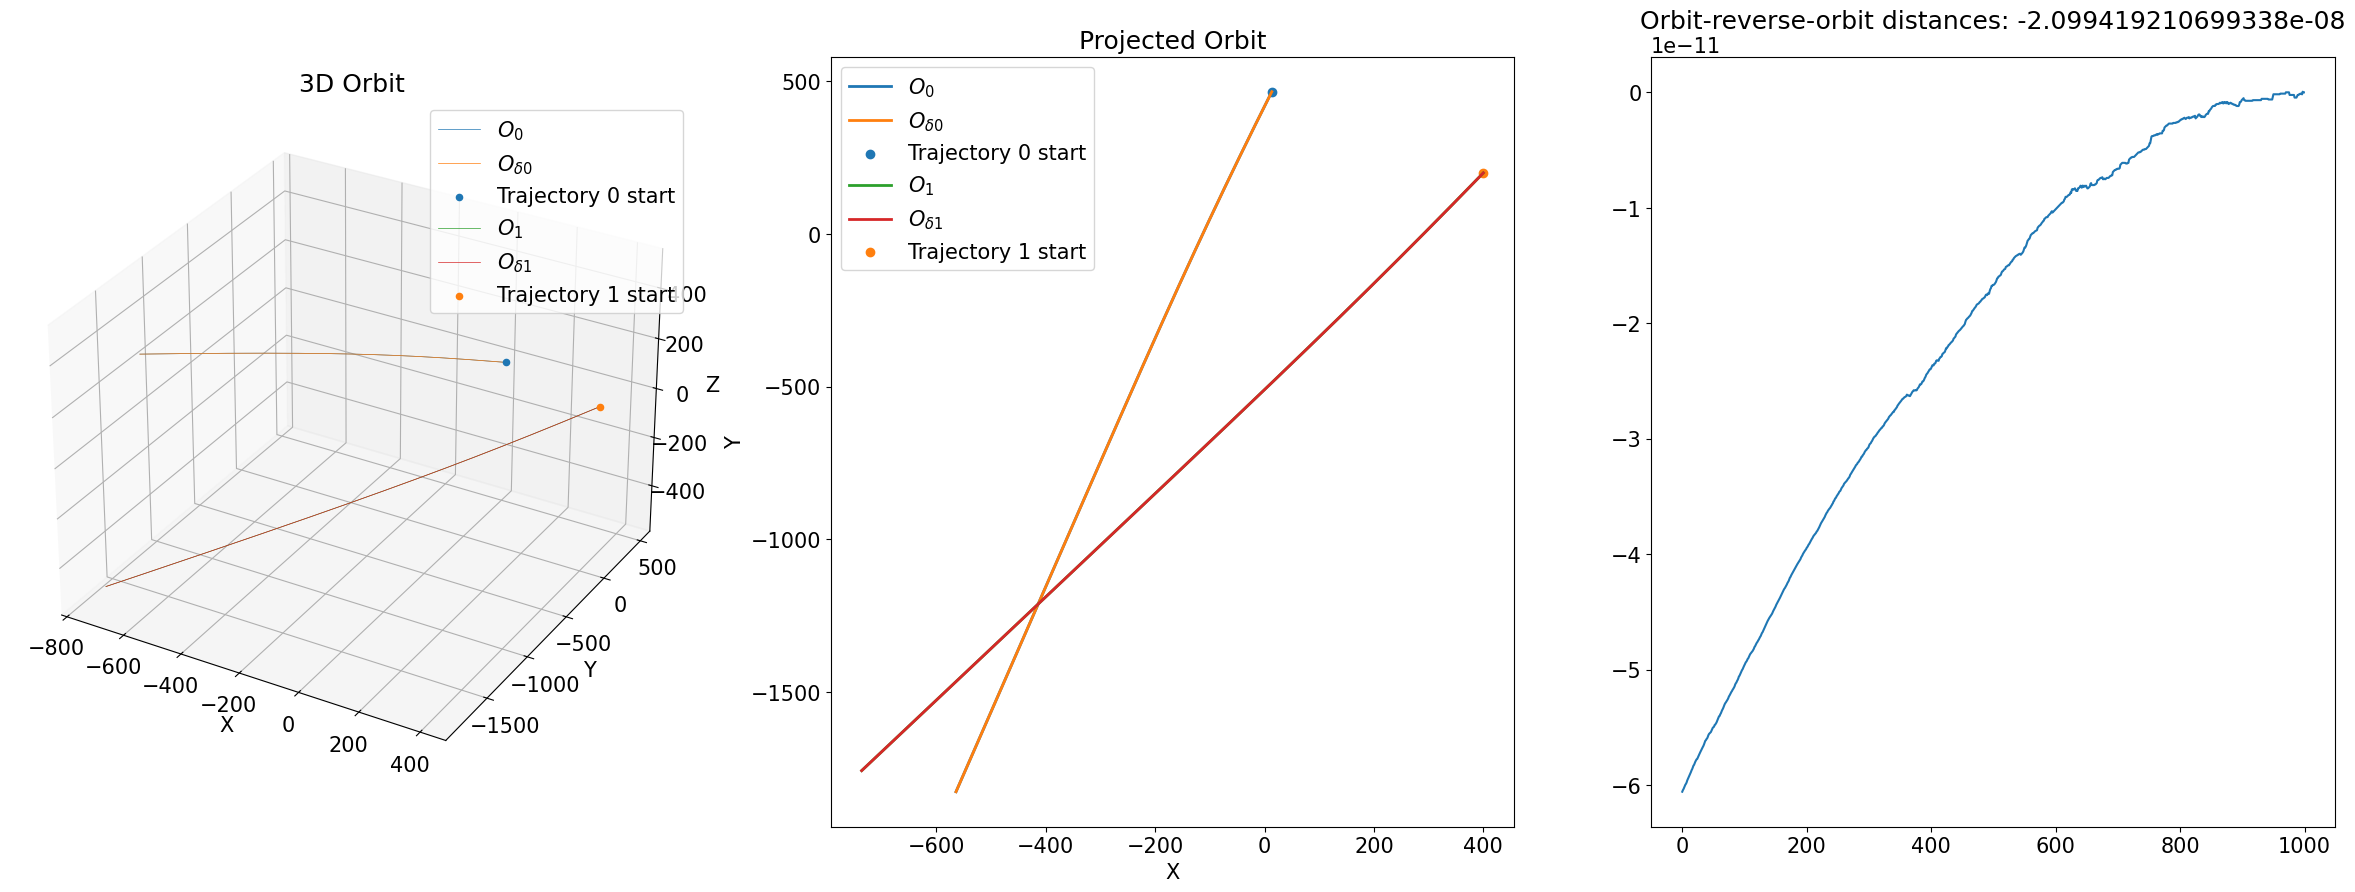

In [7]:
plot_from_init(result_to_init(0))

{0: array([-186.54999733, -131.89983368,    0.        ,    0.        ,
         -0.89057001,    0.        ]), 1: array([-400.        ,   70.59774399, -454.32125926,   -2.37169857,
         -2.        ,    1.88996321])}
{0: np.float64(0.0010497951437150425), 1: np.float64(7.665671415290098e-05)}


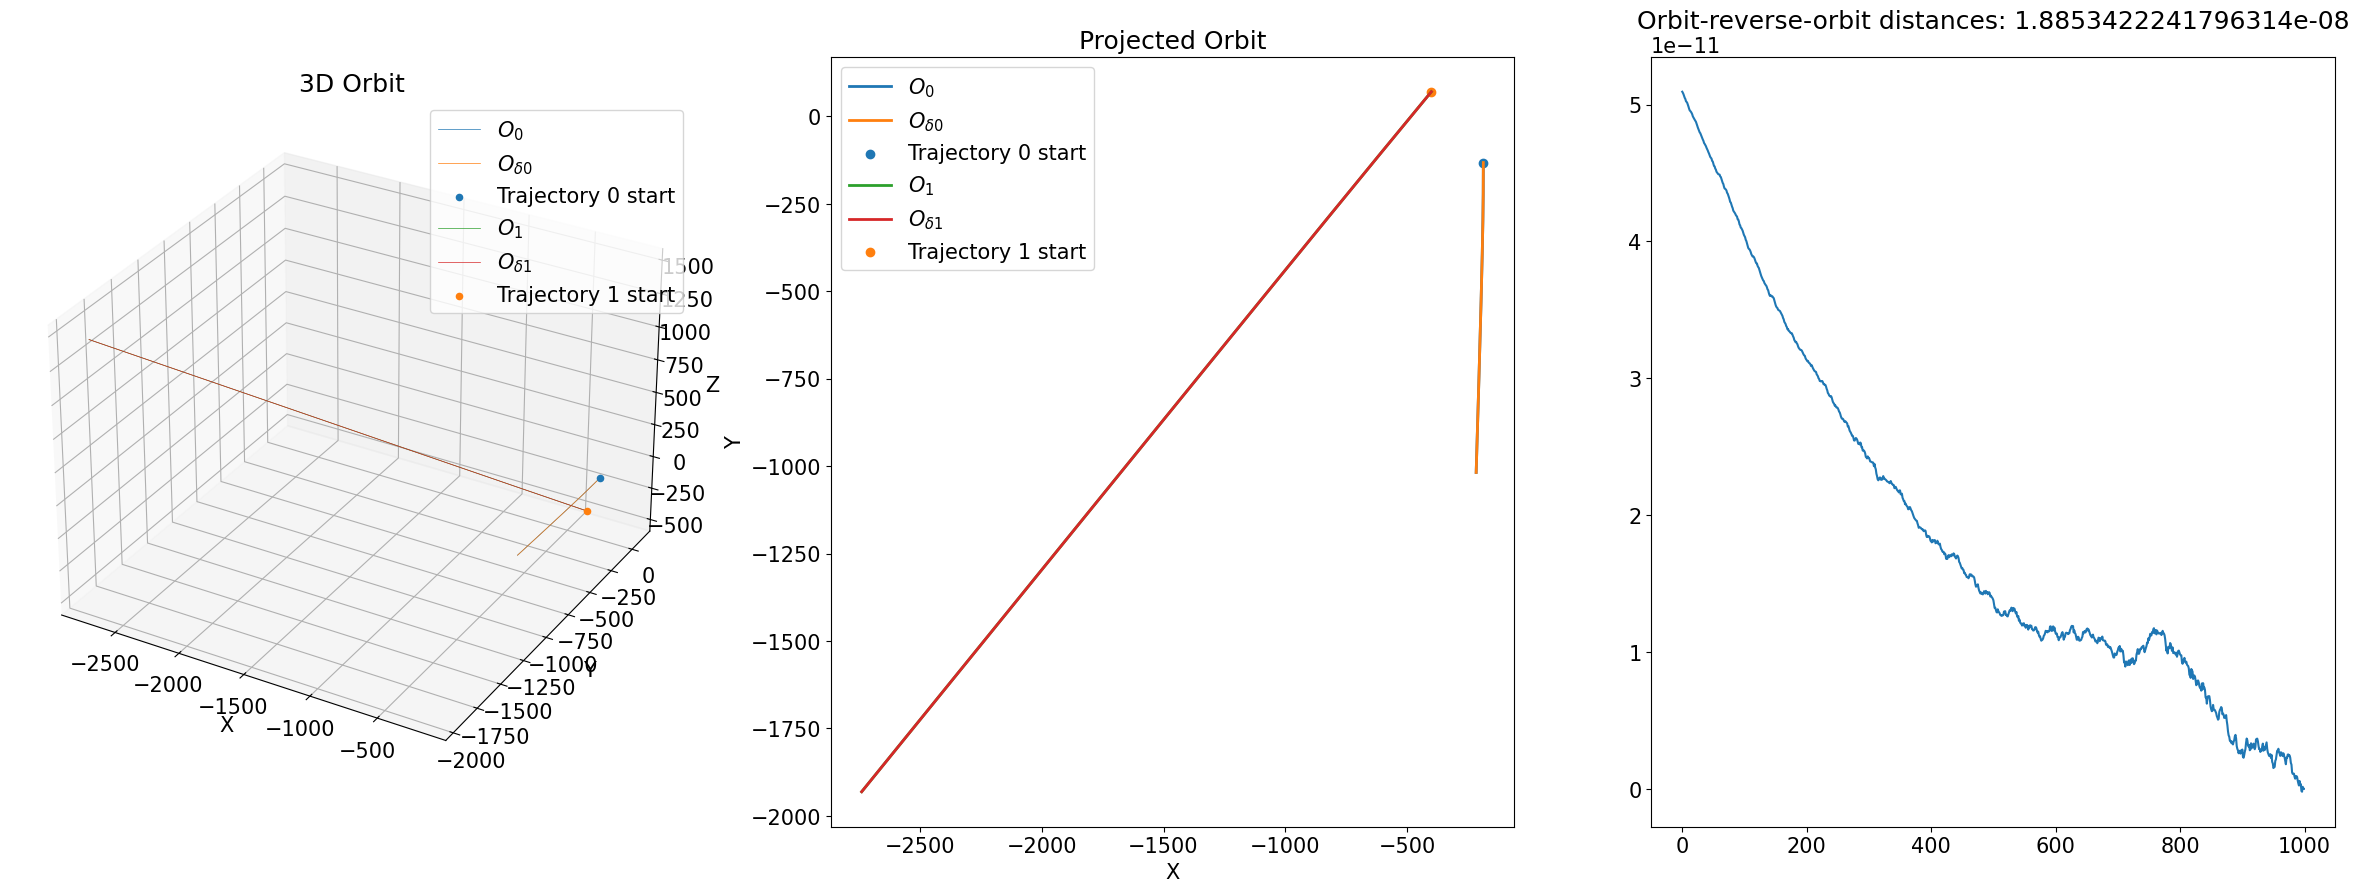

In [8]:
plot_from_init(result_to_init(1))

{0: array([-600.        ,    0.        ,  400.        ,    0.        ,
          0.        ,   -1.18957456]), 1: array([-272.80249   , -232.50788152,  200.        ,   -6.        ,
         -2.        ,    1.04101054])}
{0: np.float64(0.00110309611715676), 1: np.float64(3.4876787403471315e-06)}


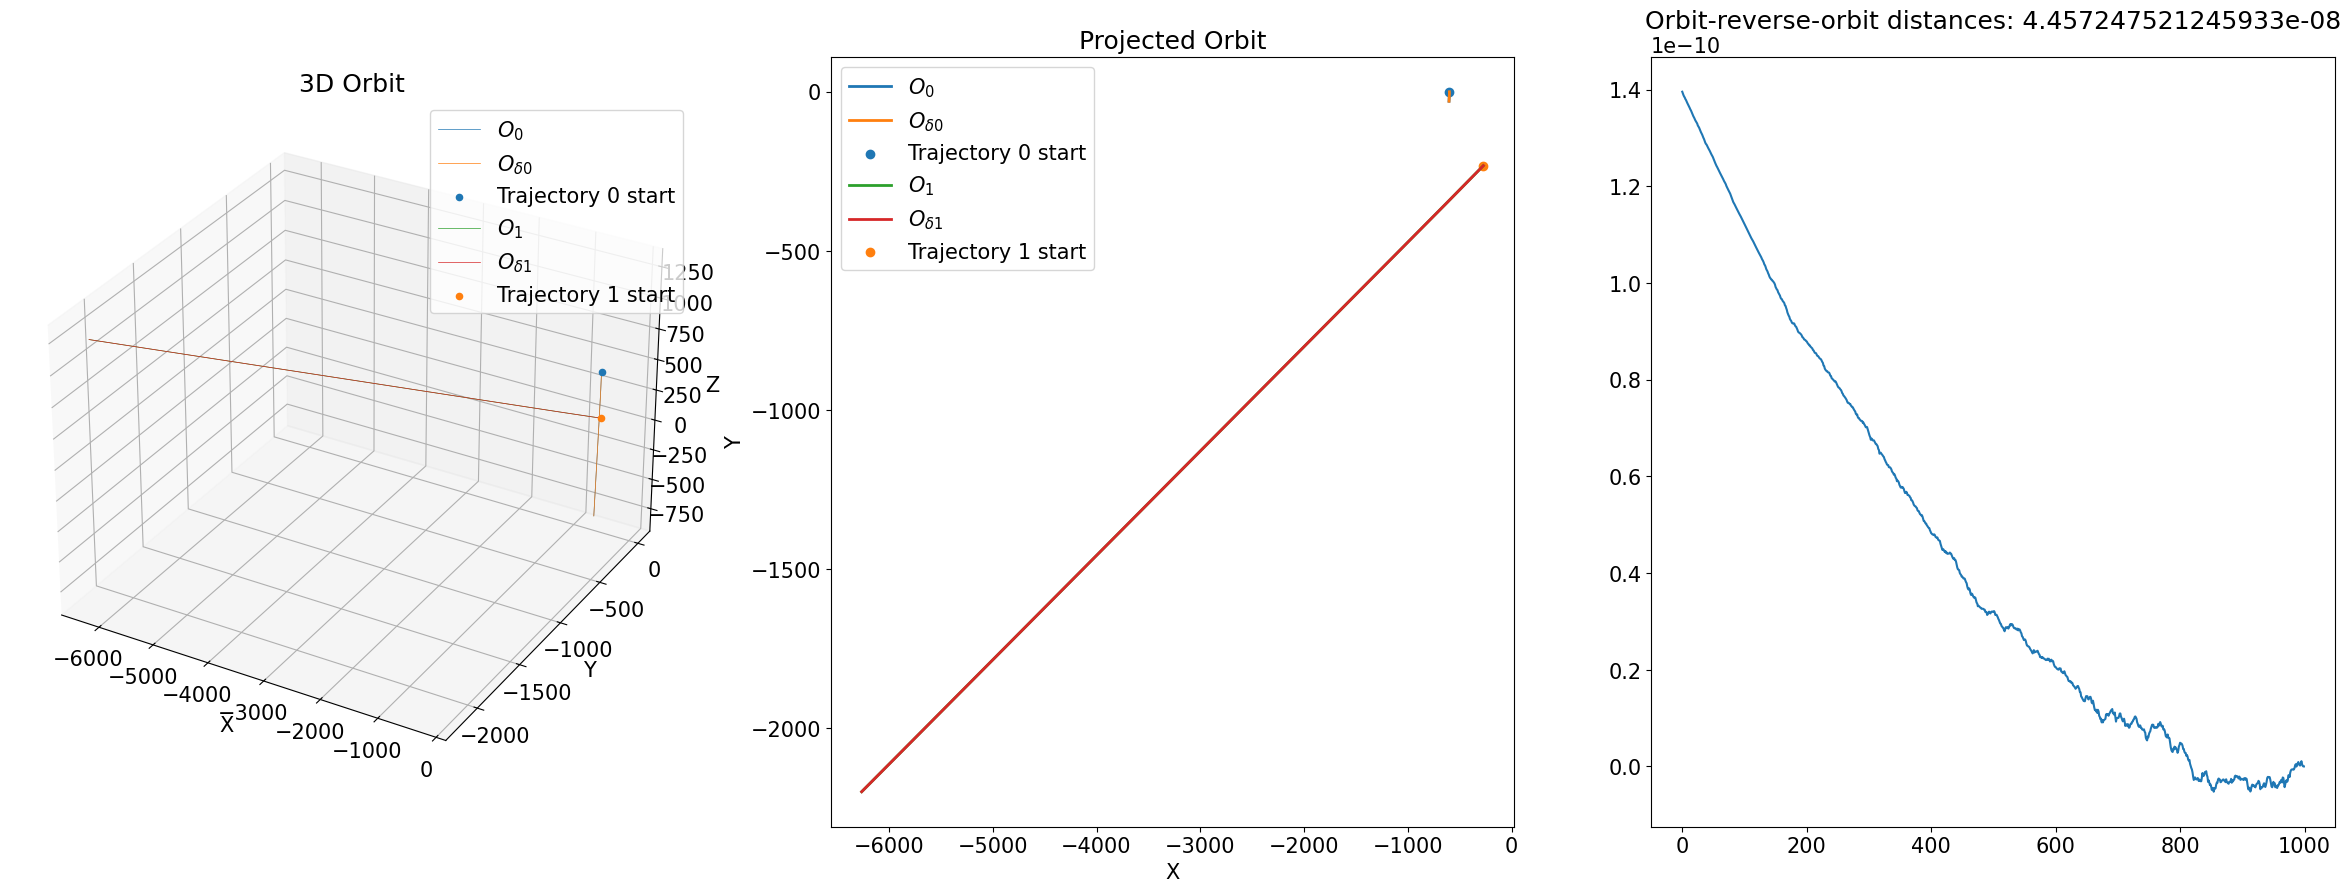

In [9]:
plot_from_init(result_to_init(5))

{0: array([  31.45677447, -328.50233018, -200.        ,   -2.        ,
          1.1558472 ,    0.        ]), 1: array([ -53.93235981, -587.12030202, -400.        ,    2.        ,
         -0.90376847,    2.73944271])}
{0: np.float64(0.0003581852847423135), 1: np.float64(0.00010312966115367567)}


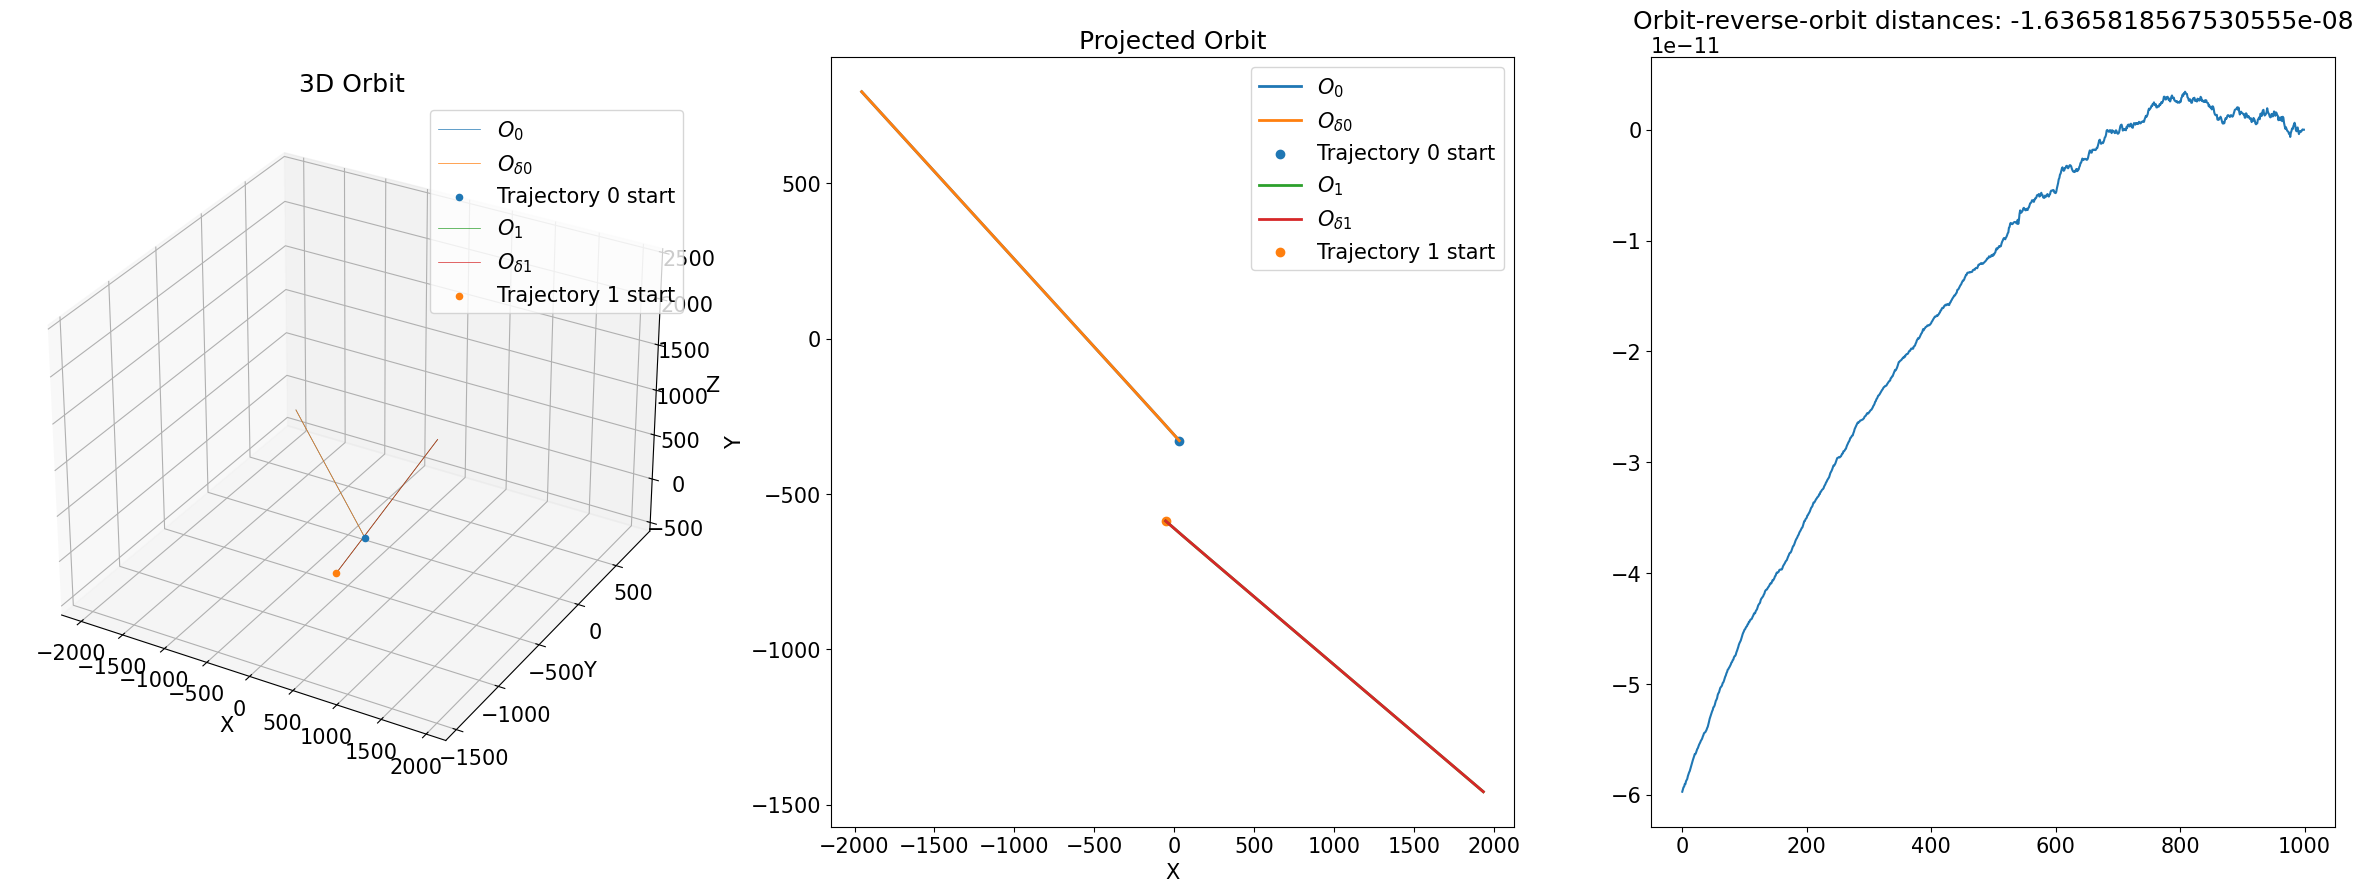

In [10]:
plot_from_init(result_to_init(3))

{0: [0, 400, 0, -1, 0, 0], 1: [0, 0, 0, 1, 0, 0]}
{0: np.float64(0.0010600429966101195), 1: np.float64(0.0010653619900276561)}


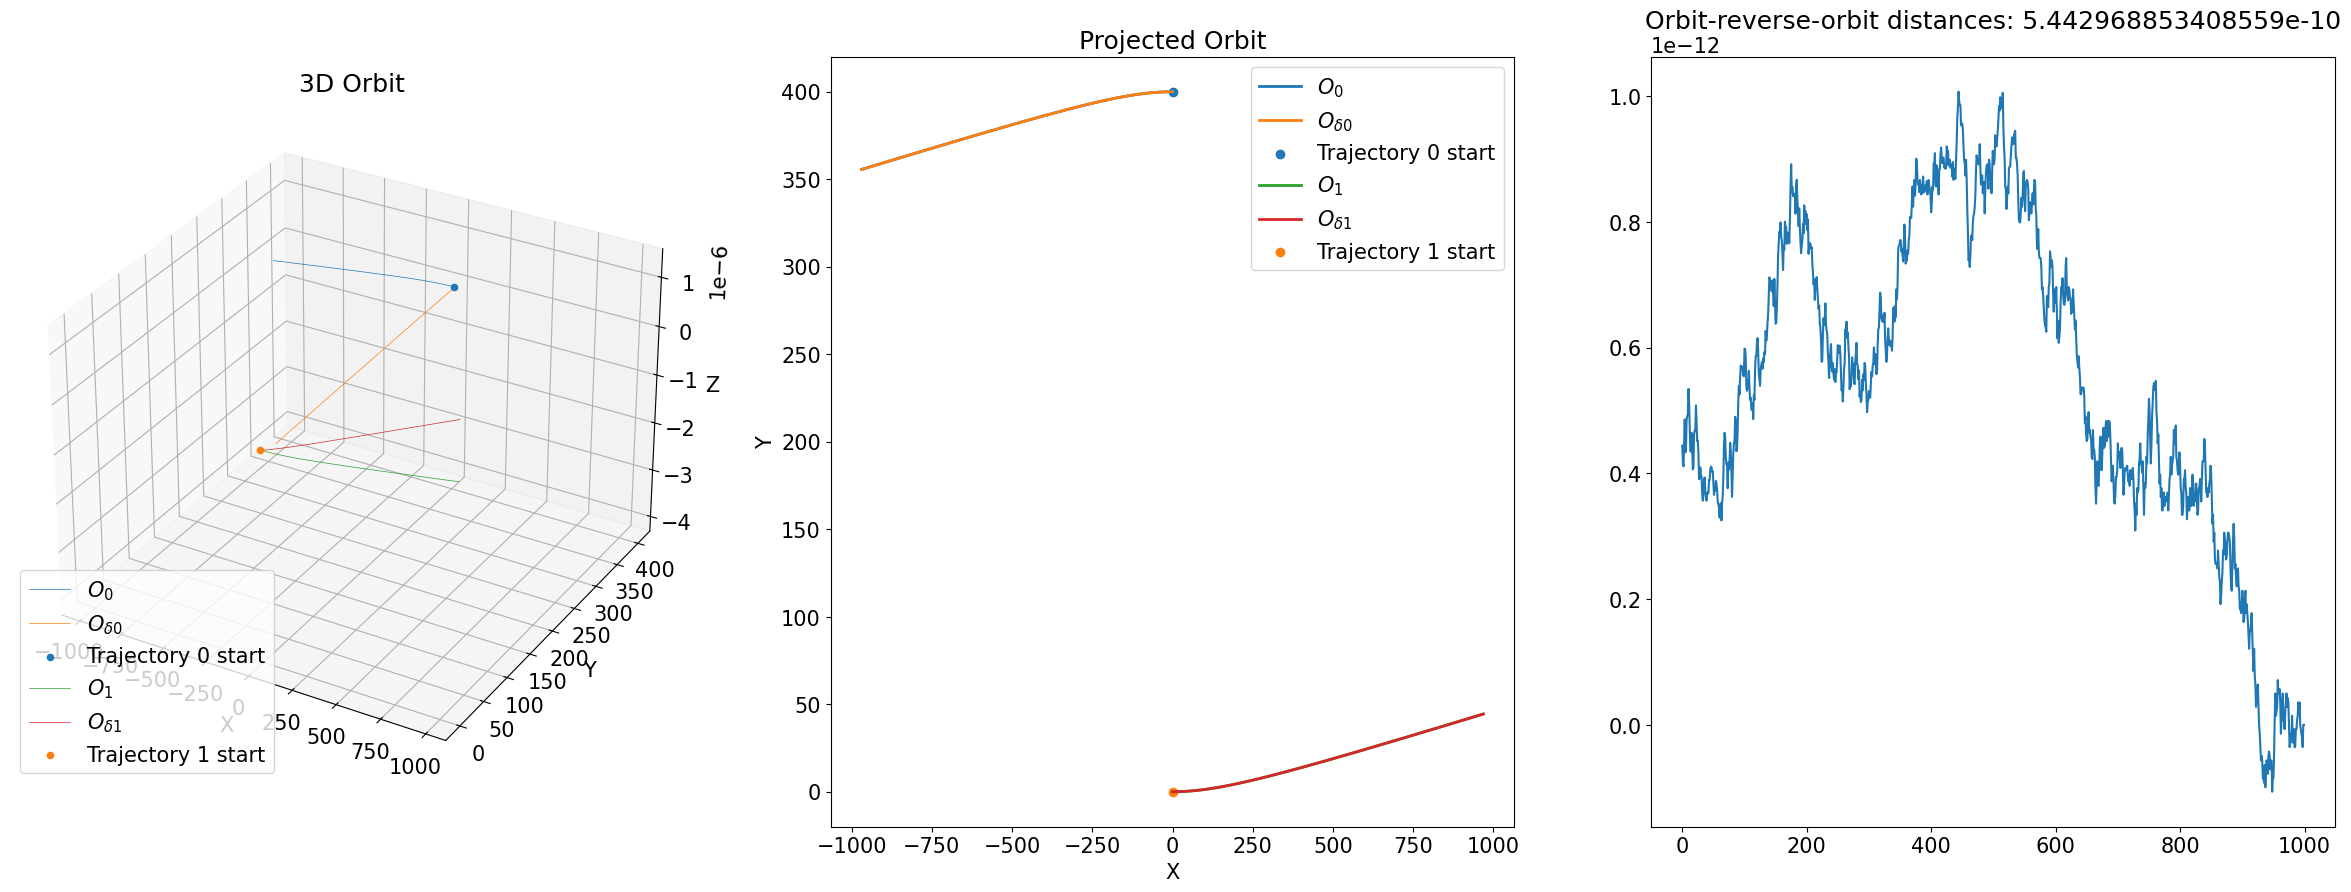

In [12]:
initparams = {0:[0,400,0,-1,0,0], 1:[0,0,0,1,0,0]}
plot_from_init(initparams)